<a href="https://colab.research.google.com/github/yingtongxiong/MLCnotebooks/blob/xytExercise/6_integration_with_machine_learning_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python3 -m  pip install mlc-ai-nightly -f https://mlc.ai/wheels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://mlc.ai/wheels
     |████████████████████████████████| 45.5 MB 1.2 MB/s 


In [2]:
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [3]:
import torch
import torch.nn as nn
from torch import fx
from torch.nn import functional as F

## 从张量表达式构造TensorIR

In [4]:
from tvm import te

In [5]:
A = te.placeholder((128, 128), name="A", dtype="float32")
B = te.placeholder((128, 128), name="B", dtype="float32")

In [6]:
type(A)

tvm.te.tensor.Tensor

In [7]:
A.shape

[128, 128]

In [10]:
def te_matmul(A: te.Tensor, B: te.Tensor) -> te.Tensor:
  assert A.shape[1] == B.shape[0]
  n = A.shape[0]
  m = B.shape[1]
  k = te.reduce_axis((0, A.shape[1]), name="k")
  return te.compute((n, m), lambda i, j: te.sum(A[i, k] * B[k, j], axis=k), name="matmul")

In [11]:
C = te_matmul(A, B)

In [12]:
te.create_prim_func([A, B, C]).show()

In [13]:
def te_relu(A: te.Temsor) -> te.Tensor:
  return te.compute(A.shape, lambda *i: te.max(A(*i), 0), name="relu")

In [14]:
X1 = te.placeholder((10,), name="X1", dtype="float32")
Y1 = te_relu(X1)
te.create_prim_func([X1, Y1]).show()

In [16]:
X2 = te.placeholder((10, 20), name="X2", dtype="float32")
Y2 = te_relu(X2)
te.create_prim_func([X2, Y2]).show()

In [17]:
C = te_matmul(A, B)
D = te_relu(C)

In [18]:
te.create_prim_func([A, B, D]).show()

In [19]:
te.create_prim_func([A, B, C, D]).show()

## 使用BlockBuilder构造IRModule

In [20]:
A = relax.Var("A", (128, 128), relax.DynTensorType(2, "float32"))
B = relax.Var("B", (128, 128), relax.DynTensorType(2, "float32"))

In [22]:
bb = relax.BlockBuilder()

with bb.function("main"):
  with bb.dataflow():
    C = bb.emit_te(te_matmul, A, B)
    D = bb.emit_te(te_relu, C)
    R = bb.emit_output(D)
  bb.emit_func_output(R, params=[A, B])

MyModule = bb.get()
MyModule.show()

## 从PyTorch导入模型

In [25]:
class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.weight = nn.Parameter(torch.randn(128, 128))
  
  def forward(self, x):
    x = torch.matmul(x, self.weight)
    x = torch.relu(x)
    return x

In [26]:
model = MyModel()
fx_module = fx.symbolic_trace(model)
type(fx_module)

torch.fx.graph_module.GraphModule.__new__.<locals>.GraphModuleImpl

In [27]:
fx_module.graph.print_tabular()

opcode         name    target                                                     args         kwargs
-------------  ------  ---------------------------------------------------------  -----------  --------
placeholder    x       x                                                          ()           {}
get_attr       weight  weight                                                     ()           {}
call_function  matmul  <built-in method matmul of type object at 0x7f4922cbe940>  (x, weight)  {}
call_function  relu    <built-in method relu of type object at 0x7f4922cbe940>    (matmul,)    {}
output         output  output                                                     (relu,)      {}


In [29]:
named_modules = dict(fx_module.named_modules())
print(named_modules)

{'': MyModel()}


In [43]:
call_function_map = {
      torch.matmul: "map_matmul",
      torch.relu: "map_relu",
    }
for node in fx_module.graph.nodes:
  if (node.op == "call_function"):
    print(node, node.op, node.target)
    print(call_function_map[node.target])
    print(node.args)

print(torch.matmul)

matmul call_function <built-in method matmul of type object at 0x7f4922cbe940>
map_matmul
(x, weight)
relu call_function <built-in method relu of type object at 0x7f4922cbe940>
map_relu
(matmul,)
<built-in method matmul of type object at 0x7f4922cbe940>


In [42]:
attr = getattr(fx_module, "weight")
attr

Parameter containing:
tensor([[-0.2215, -0.2699, -0.6942,  ...,  1.7790, -0.4581, -0.4619],
        [ 1.1434,  0.7486, -0.4692,  ...,  0.9149,  0.3197,  1.3501],
        [-1.0564, -1.1003, -0.8986,  ...,  0.3532,  0.2470,  0.7024],
        ...,
        [-0.3518,  1.3633,  0.7752,  ...,  0.8245,  0.5225,  1.3732],
        [-2.0400, -0.2198,  0.5245,  ..., -1.2201,  0.4715, -0.1400],
        [-1.2230,  0.3222,  0.7500,  ..., -1.4332,  0.6599,  0.7575]],
       requires_grad=True)

In [50]:
def map_param(param: nn.Parameter):
  ndim = len(param.data.shape)
  return relax.const(
      param.data.cpu().numpy(), relax.DynTensorType(ndim, "float32")
  )

def fetch_attr(fx_mod, target: str):
  '''Helper function to fetch an attr'''
  target_atoms = target.split('.')
  attr_itr = fx_mod
  for i, atom in enumerate(target_atoms):
    if not hasattr(attr_itr, atom):
      raise RuntimeError(f"Node reference nonexistant target {'.'.join(target_atoms[:i])}")
    attr_itr = getattr(attr_itr, atom)
  return attr_itr

def from_fx(fx_mod, input_shapes, call_function_map, call_module_map):
  input_index = 0
  node_map = {}
  named_modules = dict(fx_mod.named_modules())

  bb = relax.BlockBuilder()

  fn_inputs = []
  fn_output = None

  with bb.function("main"):
    with bb.dataflow():
      for node in fx_mod.graph.nodes:
        if node.op == "placeholder":
          # create input placeholder
          shape = input_shapes[input_index]
          input_index += 1
          input_var = relax.Var(
              node.target, shape, relax.DynTensorType(len(shape), "float32")
          )
          fn_inputs.append(input_var)
          node_map[node] = input_var
        elif node.op == "get_attr":
          node_map[node] = map_param(fetch_attr(fx_mod, node.target))
        elif node.op == "call_function":
          node_map[node] = call_function_map[node.target](bb, node_map, node)
        elif node.op == "call_module":
          named_module = named_modules[node.target]
          node_map[node] = call_module_map[type(named_module)](bb, node_map, node, named_module)
        elif node.op == "output":
          output = node_map[node.args[0]]
          assert fn_output is None
          fn_output = bb.emit_output(output)
    bb.emit_func_output(output, fn_inputs)
  return bb.get()

In [51]:
def map_matmul(bb, node_map, node: fx.Node):
  A = node_map[node.args[0]]
  B = node_map[node.args[1]]
  return bb.emit_te(te_matmul, A, B)

def map_relu(bb, node_map, node: fx.Node):
  A = node_map[node.args[0]]
  return bb.emit_te(te_relu, A)

MyModule = from_fx(
    fx_module,
    input_shapes=[(1, 128)],
    call_function_map = {
        torch.matmul: map_matmul,
        torch.relu: map_relu,
    },
    call_module_map={},
)

MyModule.show()

In [52]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



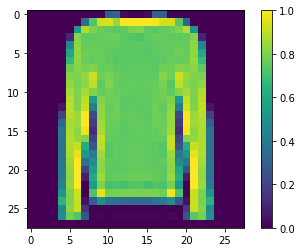

Class: Pullover


In [53]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [54]:
# Hide outputs
!wget -nc https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

--2022-10-16 03:33:57--  https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl [following]
--2022-10-16 03:33:58--  https://raw.githubusercontent.com/mlc-ai/web-data/main/models/fasionmnist_mlp_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407396 (398K) [application/octet-stream]
Saving to: ‘fasionmnist_mlp_params.pkl’

fasionmnist_mlp_par 100%[===================>] 397.85K  --.-KB/s    in 0.02s   

2022-10-16 03:33:58 (23.3 MB/s) - ‘fasionmnist_mlp_params.p

In [55]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.linear0 = nn.Linear(784, 128, bias=True)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(128, 10, bias=True)

    def forward(self, x):
        x = self.linear0(x)
        x = self.relu(x)
        x = self.linear1(x)
        return x

In [56]:
import pickle as pkl

mlp_model = MLP()

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))
mlp_model.linear0.weight.data = torch.from_numpy(mlp_params["w0"])
mlp_model.linear0.bias.data = torch.from_numpy(mlp_params["b0"])
mlp_model.linear1.weight.data = torch.from_numpy(mlp_params["w1"])
mlp_model.linear1.bias.data = torch.from_numpy(mlp_params["b1"])

In [57]:
torch_res = mlp_model(torch.from_numpy(img.reshape(1, 784)))

pred_kind = np.argmax(torch_res.detach().numpy(), axis=1)
print("Torch Prediction:", class_names[pred_kind[0]])

Torch Prediction: Pullover


In [58]:
from tvm import topi

def map_nn_linear(bb, node_map, node, nn_mod):
  x = node_map[node.args[0]]
  w = map_param(nn_mod.weight)
  if nn_mod.bias is not None:
    b = map_param(nn_mod.bias)
  y = bb.emit_te(topi.nn.dense, x, w)
  return bb.emit_te(topi.add, y, b)

def map_nn_relu(bb, node_map, node, nn_mod):
  return map_relu(bb, node_map, node)

MLPModule = from_fx(
    fx.symbolic_trace(mlp_model),
    input_shapes=[(1, 784)],
    call_function_map={},
    call_module_map={
        torch.nn.Linear: map_nn_linear,
        torch.nn.ReLU: map_nn_relu,
    },
)

MLPModule.show()

In [59]:
ex = relax.vm.build(MLPModule, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())
data_nd = tvm.nd.array(img.reshape(1, 784))

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MLPModule Prediction:", class_names[pred_kind[0]])

MLPModule Prediction: Pullover


In [60]:
def map_nn_relu_op(bb, node_map, node, nn_mod):
    A = node_map[node.args[0]]
    return bb.emit(relax.op.relu(A))

def map_nn_linear_op(bb, node_map, node, nn_mod):
    x = node_map[node.args[0]]
    w = map_param(nn_mod.weight)
    if nn_mod.bias is not None:
        b = map_param(nn_mod.bias)
    y = bb.emit(relax.op.dense(x, w))
    return bb.emit(relax.op.add(y, b))

MLPModuleHighLevel = from_fx(
    fx.symbolic_trace(mlp_model),
    input_shapes = [(1, 784)],
    call_function_map={
    },
    call_module_map={
        torch.nn.Linear: map_nn_linear_op,
        torch.nn.ReLU: map_nn_relu_op,
    },
)

MLPModuleHighLevel.show()